<h1 style="font-size: 200%;color: darkgreen; font-weight: bold; text-align:center">Numerical Simulation Laboratory 2021</h1>

<p style="text-align:center"><b>Author:</b> Giacomo Riccardo Hvaring</p>
    
---
    

# 7.  Monte Carlo simulation of the Canonical (NVT) Ensemble

## exercise 7.1

Use the Monte Carlo NVT code to print out **instantaneous** values of potential energy per particle, $V/N$, and pressure, $P$, for **equilibrated** Monte Carlo simulations (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:

- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Then, with the data generated

<p class="assignement"> Compute (in Python) and plot the autocorrelation functions of $U/N$ and $P$ to estimate how large the blocks in your simulations should be.</p>

In [1]:
from libsim import *                        # module containing some handy functions for the labs

results_directory += "lab_07/"              # where to look for the data
HTML(custom_css())   

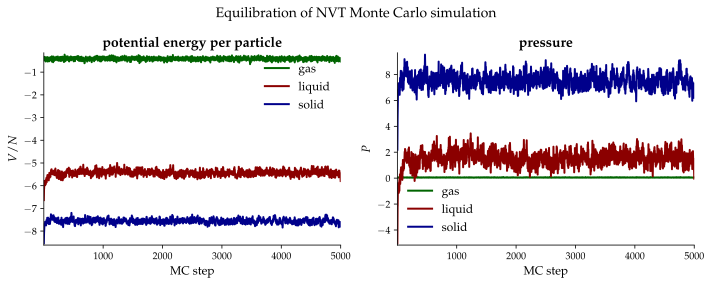

In [2]:
endpoint = 5000
color = {'solid': 'darkblue', 'liquid': 'darkred', 'gas': 'darkgreen'}

def potential_and_pressure(ax, phase):
    potential = np.loadtxt(results_directory + "potential_" + phase[:3] + ".dat")
    pressure = np.loadtxt(results_directory + "pressure_" + phase[:3] + ".dat")
    ax[0].plot(potential[:endpoint,0], potential[:endpoint,1], c=color[phase], label=phase);
    ax[1].plot(pressure[:endpoint,0], pressure[:endpoint,1], c=color[phase], label=phase);
    
fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.suptitle('Equilibration of NVT Monte Carlo simulation')

for phase in ['gas', 'liquid', 'solid']:
    potential_and_pressure(ax, phase)

set_labels(ax[0], "potential energy per particle", "MC step", "$V/N$")
set_labels(ax[1], "pressure", "MC step", "$P$")
ax[0].legend()
ax[1].legend();

In [3]:
np.linspace(0, 9, 10, dtype=int)
print([i for i in range(10)])
print(np.linspace(0, 9, 4, dtype=int))
print(np.linspace(0, 9, 10, dtype=int))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0 3 6 9]
[0 1 2 3 4 5 6 7 8 9]


In [4]:
begin = 500
points = 100
times = np.linspace(0, 5000, points)

def auto_corr(data, t):
    mean = np.mean(data)
    variance = np.var(data)
    values = [ data[i]*data[i+int(t)] for i in range(data.size-int(t)) ]
    return ( np.mean(values) - mean**2 ) / variance

def plot_autocorrelation(ax, quantity, phase):
    data = np.loadtxt(results_directory + quantity + '_' + phase[:3] + '0.dat')[begin:,1]
    if quantity == 'pressure':
        times = np.linspace(0, 500, points)
    else:
        times = np.linspace(0, 500, points)
    g = [ auto_corr(data, t) for t in times ]
    ax.plot(times, g, label=phase);

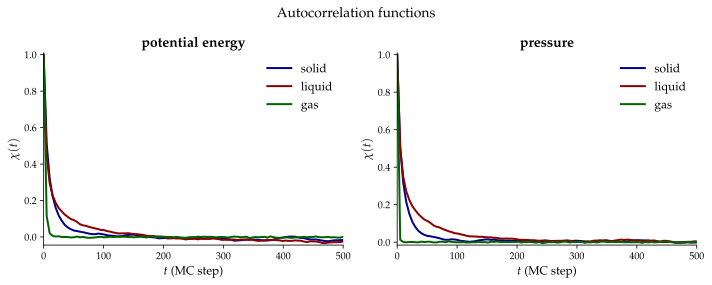

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Autocorrelation functions')

for phase in ['solid', 'liquid', 'gas']:
    plot_autocorrelation(ax[0], 'potential', phase)
    set_labels(ax[0], 'potential energy', '$t$ (MC step)', '$\chi(t)$')
    plot_autocorrelation(ax[1], 'pressure', phase)
    set_labels(ax[1], 'pressure', '$t$ (MC step)', '$\chi(t)$')
    ax[0].legend()
    ax[1].legend();

The gas autocorrelation seems to fall off more quickly than the liquid and solid. This can be a consequence of the "big leaps" one makes in configuration space with the Metropolis algorithm to keep the acceptance rate as close to a 50% as possible (in this case it was just over 60%).

For the liquid and solid phase after 200 MC steps (which consist of trying to move with the metropolis algorithm the _entire_ system once) the measurements are not correlated anymore. So any length greater than 400 MC steps will produce uncorrelated blocks for the final data analysis.

<p class="assignement"> Study the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different sizes of the blocks, from $L=M/N=10$ to $L=5\times 10^3$, $N$ being the total number of blocks. Then plot the statistical uncertainties as functions of $L$.</p>

<p class="remark"> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

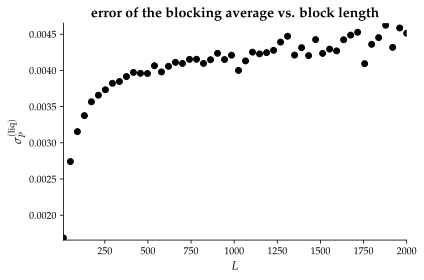

In [6]:
fig, ax = plt.subplots()

begin = 500 # remove equilibration points
phase = 'liq'
quantity = 'pressure'
data = np.loadtxt(results_directory + quantity + '_' + phase + '0.dat')[begin:,1]
mean = np.mean(data)
size = data.size

def error(data, L):
    blocks = [ data[i:i+L] for i in np.arange(0, data.size - L, int(L)) ]
    squared_means = np.array([ np.mean(block)**2 for block in blocks ])
    variance = (np.mean(squared_means) - mean**2)/(squared_means.size - 1)
    return np.sqrt(variance)

points = 50
for length in np.linspace(10, 2000, points):
    #print(length, size - int(size/length)*int(length) )
    ax.scatter(length, error(data, int(length)), c='k')
set_labels(ax, 'error of the blocking average vs. block length', '$L$', f'$\sigma_P^{{\\rm ({phase})}}$')

<p class='remark'> The general trend is toward a saturation as the block length increases, but some noise is present due to the exclusion of part of the data in the subdivision of the sample.</p>

## exercise 7.2


<p class="assignement"> Calculate the radial distribution function, $g(r)$, where $r\in \left[ 0, L/2\right]$ is the radial distance $r$ between two particles. Then calculate the average value of $g(r)$ in each block (output file: output.gofr.0), and the final average values of $g(r)$ (output file: output.gave.0) together with their uncertainties.</p>

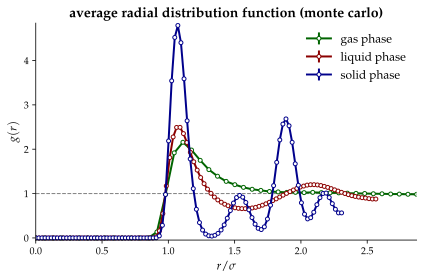

In [7]:
phases = ['gas', 'liquid', 'solid']
nparticles = 108
densities = np.array([0.05, 0.8, 1.1])
volumes = nparticles / densities
L = volumes ** (1/3.)
colors = ['darkgreen', 'darkred', 'darkblue']

fig, ax = plt.subplots()
set_labels(ax, 'average radial distribution function (monte carlo)', '$r/\\sigma$', '$g(r)$')

def final_errors_g(measurements):
    mean = np.mean(measurements, axis=0)
    mean2 = np.mean(measurements**2, axis=0)
    return np.sqrt((mean2 - mean**2)/(measurements.shape[0]  - 1))

for phase, i in zip(phases, range(3)):
    g = np.loadtxt(results_directory + 'radial_dist_' + phase[:3] + '.dat')
    g_mean = np.mean(g, axis=0)
    g_err = final_errors_g(g)
    r = np.linspace(0, 0.5*L[i], 100)
    ax.axhline(1, color='k', lw=1, ls='--', alpha=0.2)
    #ax.plot(r, g_mean, ls='-', c=colors[i], lw=1)
    end = 100
    if phase == 'gas':
        end = 45 # truncating the tail of the gas for better visibility
    ax.errorbar(r[:end], g_mean[:end], ls='-', yerr=g_err[:end], c=colors[i], markerfacecolor='w', marker='o', ms=4, fillstyle='full', label=phase + ' phase')
    ax.legend();

## exercise 7.3

<p class="assignement"> Calculate the radial distribution function, $g(r)$, in the <b>previously used</b> Molecular Dynamics code</p>

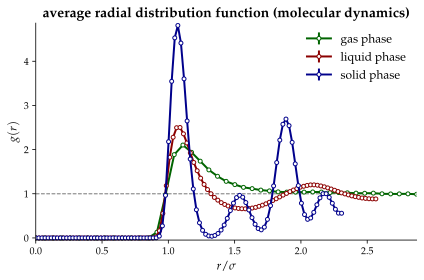

In [8]:
phases = ['gas', 'liquid', 'solid']
nparticles = 108
densities = np.array([0.05, 0.8, 1.1])
volumes = nparticles / densities
L = volumes ** (1/3.)
colors = ['darkgreen', 'darkred', 'darkblue']

fig, ax = plt.subplots()
set_labels(ax, 'average radial distribution function (molecular dynamics)', '$r/\\sigma$', '$g(r)$')

for phase, i in zip(phases, range(3)):
    g = np.loadtxt(results_directory + 'md_radial_dist_' + phase[:3] + '.dat')
    g_mean = np.mean(g, axis=0)
    g_err = final_errors_g(g)
    r = np.linspace(0, 0.5*L[i], 100)
    ax.axhline(1, color='k', lw=1, ls='--', alpha=0.2)
    #ax.plot(r, g_mean, ls='-', c=colors[i], lw=1)
    end = 100
    if phase == 'gas':
        end = 45 # truncating the tail of the gas for better visibility
    ax.errorbar(r[:end], g_mean[:end], ls='-', yerr=g_err[:end], c=colors[i], markerfacecolor='w', marker='o', ms=4, fillstyle='full', label=phase + ' phase')
    ax.legend();

## exercise 7.4

By means of your upgraded MC code, equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:

1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

<p class="assignement"> Plot the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$... <b>in SI units!</b>, comparing your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</p>

The following result is not compatible when compared with the Molecular Dynamics (MD) results, even when the temperature of the NVT simulation is set to the *mean* temperature of the corresponding MD simulation. I suppose there is a bug in the code somewhere in the measurement of the quantities, which  I could not find unfortunately, because I tried to:
- correct for the difference in temperature between the MD simulations and the targets
- add tail corrections to the MD code
- calculate separately the radial distribution function
    
None of these produced good enough compatibility.

In [10]:
# it takes a while, but the result is worth it!

color = {'solid': 'darkblue', 'liquid': 'darkred', 'gas': 'darkgreen'}
md_color = {'solid': 'blue', 'liquid': 'red', 'gas': 'green'}

L = {'solid': 500, 'liquid': 500, 'gas': 100 }
shift = 500
nblocks = 100

T_factor = 120
kb = 1.38064852 # x10^(-23)
e_factor = T_factor * kb
sigma = 0.34 # x10^(-9)
P_factor = e_factor / sigma**3 # x10^4


def block_averages(data, L):
    blocks = np.array([ data[i:i+L] for i in np.arange(0, nblocks * L, L) ])
    averages = np.mean(blocks, axis=1)
    running_average = np.array([ np.mean(averages[:end+1]) for end in range(nblocks) ])
    running_average2 = np.array([ np.mean((averages**2)[:end+1]) for end in range(nblocks) ])
    errors = np.sqrt( running_average2 - running_average**2 )
    denom = np.arange(nblocks) + 1
    return running_average, errors / np.sqrt(denom)

def potential_and_pressure(ax, phase):
    # NVT simulation at the temperature indicated in the assignement
    potential = np.loadtxt(results_directory + "potential_" + phase[:3] + "0.dat")[shift:,1]
    pressure = np.loadtxt(results_directory + "pressure_" + phase[:3] + "0.dat")[shift:,1]
    mc_potential0, mc_err_potential0 = block_averages(potential, L[phase])
    mc_pressure0, mc_err_pressure0 = block_averages(pressure, L[phase])
    
    # NVT simulation at the mean temperature of the corresponding molecular dynamics simulation
    potential = np.loadtxt(results_directory + "potential_" + phase[:3] + ".dat")[shift:,1]
    pressure = np.loadtxt(results_directory + "pressure_" + phase[:3] + ".dat")[shift:,1]
    mc_potential, mc_err_potential = block_averages(potential, L[phase])
    mc_pressure, mc_err_pressure = block_averages(pressure, L[phase])
    
    # molecular dynamics
    results_md = '../results/lab_04/'
    md_potential = np.loadtxt(results_md + 'avg_potential_' + phase[:3] + '.dat')
    md_err_potential = md_potential[:,-1]
    md_potential = md_potential[:,-2]
    md_pressure = np.loadtxt(results_md + 'avg_pressure_' + phase[:3] + '.dat')
    md_err_pressure = md_pressure[:,-1]
    md_pressure = md_pressure[:,-2]
    
    # plots
    x = np.arange(mc_potential0.size) + 1
    #diff_potential0 = (md_potential - mc_potential0) / (md_potential + mc_potential0)
    #err_potential0 = md_err_potential + mc_err_potential0 # i know i should sum them in quadrature, i am overestimating on purpose
    
    markers, caps, bars = ax[0].errorbar(x, e_factor*mc_potential0, yerr=e_factor*mc_err_potential0, alpha=0.2, ls='--', c=color[phase], label=phase + ' at $T=T^\star$');
    [bar.set_alpha(0.2) for bar in bars]
    markers, caps, bars = ax[0].errorbar(x, e_factor*md_potential, yerr=e_factor*md_err_potential, lw=1, ls='-', c=md_color[phase], label=phase + ' MD');
    [bar.set_alpha(0.2) for bar in bars]
    
    #diff_pressure0 = md_pressure - mc_pressure0
    #err_pressure0 = md_err_pressure + mc_err_pressure0 
    markers, caps, bars = ax[1].errorbar(x, P_factor*mc_pressure0, yerr=P_factor*mc_err_pressure0, alpha=0.2, ls='--', c=color[phase], label=phase + ' at $T=T^\star$')
    [bar.set_alpha(0.2) for bar in bars]
    markers, caps, bars = ax[1].errorbar(x, P_factor*md_pressure, yerr=P_factor*md_err_pressure, lw=1, ls='-', c=md_color[phase], label=phase + ' MD')
    [bar.set_alpha(0.2) for bar in bars]
    
    x = np.arange(mc_potential.size) + 1
    #diff_potential = md_potential - mc_potential
    #err_potential = md_err_potential + mc_err_potential
    
    markers, caps, bars = ax[0].errorbar(x, e_factor*mc_potential, yerr=e_factor*mc_err_potential, c=color[phase], label=phase + ' at $T = \\langle T\\rangle_{\\rm md}$');
    [bar.set_alpha(0.2) for bar in bars]
    
    #diff_pressure = md_pressure - mc_pressure
    #err_pressure = md_err_pressure + mc_err_pressure
    
    markers, caps, bars = ax[1].errorbar(x, P_factor*mc_pressure, yerr=P_factor*mc_err_pressure, c=color[phase], label=phase + ' at $T = \\langle T\\rangle_{\\rm md}$')
    [bar.set_alpha(0.2) for bar in bars]

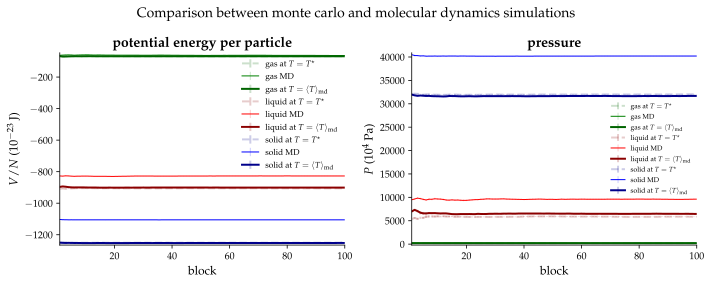

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Comparison between monte carlo and molecular dynamics simulations')

for phase in phases:
    potential_and_pressure(ax, phase)
    set_labels(ax[0], "potential energy per particle", "block", "$V/N$  ($10^{-23}$ J)")
    set_labels(ax[1], "pressure", "block", "$P$  ($10^4$ Pa)")
    ax[0].legend(fontsize='small')
    ax[1].legend(fontsize='x-small');

the solid thin lines represents the molecular dynamics blocking average, which is incompatible both with the dashed lines (MC with $T=T^\star$) and the solid thick lines (MC with $T=\langle T\rangle_{\rm MD}$).

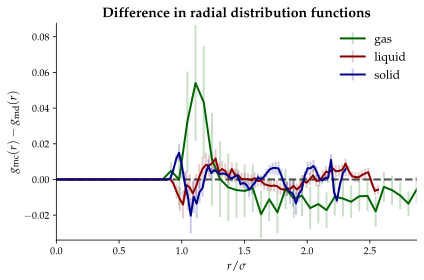

In [12]:
phases = ['gas', 'liquid', 'solid']
nparticles = 108
densities = np.array([0.05, 0.8, 1.1])
volumes = nparticles / densities
L = volumes ** (1/3.)
colors = ['darkgreen', 'darkred', 'darkblue']
fig, ax = plt.subplots()
set_labels(ax, 'Difference in radial distribution functions', '$r/\\sigma$', '$g_{\\rm mc}(r) - g_{\\rm md}(r)$')

alpha = 0.7
for phase, i in zip(phases, range(3)):
    md_g = np.loadtxt(results_directory + 'md_radial_dist_' + phase[:3] + '.dat')
    md_g_mean = np.mean(md_g, axis=0)
    md_g_err = final_errors_g(md_g)
    mc_g = np.loadtxt(results_directory + 'radial_dist_' + phase[:3] + '.dat')
    mc_g_mean = np.mean(mc_g, axis=0)
    mc_g_err = final_errors_g(mc_g)
    r = np.linspace(0, 0.5*L[i], 100)
    #ax.plot(r, g_mean, ls='-', c=colors[i], lw=1)
    end = 100
    if phase == 'gas':
        end = 45 # truncating the tail of the gas for better visibility
    difference = mc_g_mean[:end] - md_g_mean[:end]
    upper_error = mc_g_err[:end] + md_g_err[:end]
    markers, caps, bars = ax.errorbar(r[:end], difference, ls='-', yerr=upper_error, c=colors[i], label=phase)
    ax.axhline(0, c='k', alpha=0.3, ls='--', lw=2)
    [bar.set_alpha(alpha*0.3) for bar in bars]
    ax.legend();